The google doc that describes which variables to change and where:

https://docs.google.com/document/d/1edZSjRPdRS9AJsd3bq50_Obp5NLn2ez7644ZrqYP2KI/edit?usp=sharing

In [1]:
# defines weights for linear regression

location_dict = {
    "Virtual": 0,
    "Onsite": 0.2,
    "Offsite Local": 0.3,
    "Offsite Travel": 0.5
}

faculty_personality_dict = {
    "Easy": 0,
    "Medium": 0.2,
    "Hard": 0.3
}

faculty_complexity_dict = {
    "Easy": 0,
    "Medium": 0.2,
    "Hard": 0.3
}

accreditation_dict = {
    "No": 0,
    "Yes": 0.3
}

overall_length_dict = {
    "Single Day": 0,
    "2 - 4 Days": 0.2,
    "5-6 Days": 0.3,
    "Multi Week": 0.5
}

weekends_dict = {
    "No": 0,
    "Yes": 0.2
}

intermodular_work_dict = {
    "No": 0,
    "Yes": 0.2
}

extra_events_onsite_dict = {
    "No": 0,
    "Single": 0.2,
    "Multiple": 0.25
}

extra_events_offsite_dict = {
    "No": 0,
    "Single": 0.4,
    "Multiple": 0.5
}

num_participants_dict = {
    "≤ 30": 0,
    "30 < X < 50": 0.2,
    "> 50": 0.3
}

multiple_faculty_dict = {
    "No": 0,
    "Yes - All Rice": 0.3,
    "Yes - Mixed": 0.5
}

guest_speakers_dict = {
    "No": 0,
    "Yes": 0.2
}

coaches_dict = {
    "No": 0,
    "Yes": 0.2
}

overlapping_programs_dict = {
    "No": 0,
    "Yes": 0.2
}

program_type_dict = {
    "Open - New": 0.2,
    "Open - Existing": 0,
    "Custom - New": 0.4,
    "Custom - Existing": 0.3,
    "Partnership - New": 0.4,
    "Partnership - Existing": 0.3
}

custom_liaison_dict = {
    "Open - N/A": 0,
    "Easy": 0.1,
    "Hard": 0.2
}


In [2]:
# names of the input files
historical_data_csv_name = 'historical_data.csv'
batch_data_csv_name = 'batch_data.csv'

# Initialize weights to normalize the values for each PM
# i.e. because kelcie should be 2x of emily's values, then normalize kelcie to be on emily's 'level'
x_weight = 1.0  # Weight for PM Emily
y_weight = 0.5  # Weight for PM Kelcie
z_weight = 0.25  # Weight for PM Megan, Jenn, and Yassmine
weight_to_pm = { "Emily": x_weight,
                "Kelcie": y_weight, 
                "Megan": z_weight, 
                "Jenn": z_weight, 
                "Yassmine": z_weight}

#names of the relevant column names in this historical dataset
START_DATE_W1 = "Start Date (W1)"
END_DATE_W1 = "End Date (W1)"
START_DATE_W2 = "Start Date (W2)"
END_DATE_W2 = "End Date (W2)"

DIFF_SCORE_HISTORICAL_COL_NAME = "Difficulty Score 0-6"
DAYS_HISTORICAL_COL_NAME = "Days/Time"
BRENT_DAYS_HISTORICAL_COL_NAME = "Brent Days"
PM_HISTORICAL_COL_NAME = "PM"

#names of the relevant column names in the batch dataset

PRIORITY_BATCH_COL_NAME = "Priority PM"
BRENT_DAYS_BATCH_COL_NAME = "Brent Days"
PROGRAM_DAYS_BATCH_COL_NAME = "No. of Program Days"

In [3]:
import pandas as pd
from collections import defaultdict
'''
helper function to help clean-up/format the batch/historical data columns
'''
def custom_date_parser(x):
    try:
        return pd.to_datetime(x, format='%m.%d.%y')
    except ValueError:
        return pd.NaT  # returns 'Not-a-Time' for non-date values


In [4]:

'''
imports and clean the two given csv's
'''


# Assuming you have uploaded two files: 'batch_data.csv' and 'historical_data.csv'

# Read the batch data CSV file and parse dates, converting them to a specific format
batch_data_df = pd.read_csv(batch_data_csv_name , encoding='ISO-8859-1', 
                            parse_dates=[START_DATE_W1, END_DATE_W1, START_DATE_W2, END_DATE_W2], 
                            date_parser=custom_date_parser)


# Read the historical data CSV file and parse dates, converting them to a specific format
historical_data_df = pd.read_csv(historical_data_csv_name, encoding='ISO-8859-1', 
                                 parse_dates=[START_DATE_W1, END_DATE_W1, START_DATE_W2, END_DATE_W2], 
                                 date_parser=custom_date_parser)

# Same end date for W1 and W2 if start date exists
batch_data_df[END_DATE_W1].fillna(batch_data_df[START_DATE_W1], inplace=True)
batch_data_df[END_DATE_W2].fillna(batch_data_df[START_DATE_W2], inplace=True)
# same for historical data
historical_data_df[END_DATE_W1].fillna(historical_data_df[START_DATE_W1], inplace=True)
historical_data_df[END_DATE_W2].fillna(historical_data_df[START_DATE_W2], inplace=True)

# removes any trailing or leading white space for all elements in the csv (if it's a string)
batch_data_df = batch_data_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
historical_data_df = historical_data_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# mapping to replace buggy inputs to corrected outputs in csv
replacement_map = {
    '² 30': '≤ 30'
    # Add other potential replacements here if needed
}

# Replace the anomalies in the "Number of Participants" column
batch_data_df['Number of Participants'] = batch_data_df['Number of Participants'].replace(replacement_map)

# Check which PM is assigned and add the difficulty score, days, and Brent days
# Convert columns to numeric and set errors='coerce' to convert invalid parsing to NaN
historical_data_df[DIFF_SCORE_HISTORICAL_COL_NAME] = pd.to_numeric(historical_data_df[DIFF_SCORE_HISTORICAL_COL_NAME], errors='coerce')
historical_data_df[DAYS_HISTORICAL_COL_NAME] = pd.to_numeric(historical_data_df[DAYS_HISTORICAL_COL_NAME], errors='coerce')
historical_data_df[BRENT_DAYS_HISTORICAL_COL_NAME] = pd.to_numeric(historical_data_df[BRENT_DAYS_HISTORICAL_COL_NAME], errors='coerce')

# sanity check for 'clean' batch_data
batch_data_df.head()


,PROGRAM,Priority PM,Start Date (W1),End Date (W1),Start Date (W2),End Date (W2),Brent Days,No. of Program Days,Location,Faculty Personality,...,Intermodular Work,Extra Events - Onsite,Extra Events - Offsite,Number of Participants,Multiple Faculty,Guest Speakers,Coaches,Overlapping Program,Program Type,Custom Liason
0,RAMP,NaN,2023-09-25,2023-09-29,2023-10-06,2023-10-10,5,10,Onsite,Hard,...,Yes,Multiple,No,≤ 30,Yes - All Rice,Yes,Yes,Yes,Open - Existing,Open - N/A
1,TLA,NaN,2023-10-17,2023-10-20,NaT,NaT,4,4,Onsite,Hard,...,No,Single,No,≤ 30,No,No,No,No,Open - Existing,Open - N/A
2,TMI,NaN,2023-10-26,2023-10-27,2023-11-07,2023-11-08,2,2,Onsite,Hard,...,No,Single,No,30 < X < 50,No,No,No,Yes,Open - Existing,Open - N/A
3,SFE,NaN,2023-10-30,2023-11-01,NaT,NaT,0,3,Onsite,Medium,...,No,Single,No,≤ 30,No,No,No,No,Open - Existing,Open - N/A
4,FANFM,NaN,2023-12-12,2023-12-15,NaT,NaT,0,4,Onsite,Easy,...,No,Single,No,≤ 30,Yes - Mixed,No,No,No,Open - Existing,Open - N/A


In [5]:
'''
Define a function to calculate the difficulty for a row/program in batch_data
'''
def calculate_difficulty(row):
    difficulty = (
        location_dict[row["Location"]] +
        faculty_personality_dict[row["Faculty Personality"]] +
        faculty_complexity_dict[row["Faculty Complexity"]] +
        accreditation_dict[row["Accredidation"]] +
        overall_length_dict[row["Overall Length"]] +
        weekends_dict[row["Weekends"]] +
        intermodular_work_dict[row["Intermodular Work"]] +
        extra_events_onsite_dict[row["Extra Events - Onsite"]] +
        extra_events_offsite_dict[row["Extra Events - Offsite"]] +
        num_participants_dict[row["Number of Participants"]] +
        multiple_faculty_dict[row["Multiple Faculty"]] +
        guest_speakers_dict[row["Guest Speakers"]] +
        coaches_dict[row["Coaches"]] +
        overlapping_programs_dict[row["Overlapping Program"]] +
        program_type_dict[row["Program Type"]] +
        custom_liaison_dict[row["Custom Liason"]]
    )
    return difficulty

In [6]:
'''
Initialize mapping of PMs to all of their existing program dates
'''

PM_dates_w1 = defaultdict(set)
PM_dates_w2 = defaultdict(set)

# Iterate through the historical data and add tuple of start and end dates
for index, row in historical_data_df.iterrows():
    assigned_pm = row[PM_HISTORICAL_COL_NAME]
    
    start_w1 = row[START_DATE_W1]
    end_w1 = row[END_DATE_W1]
    start_w2 = row[START_DATE_W2]
    end_w2 = row[END_DATE_W2]

    #Add pairs of start/end dates to set for each PM
    PM_dates_w1[assigned_pm].add((start_w1, end_w1))
    PM_dates_w2[assigned_pm].add((start_w2, end_w2))

    

In [7]:
PM_difficulty = {}
PM_days = {}
PM_brent_days = {}
weighted_PM = {}

# sum up values
for pm in weight_to_pm:
    PM_difficulty[pm] = historical_data_df[historical_data_df[PM_HISTORICAL_COL_NAME] == pm][DIFF_SCORE_HISTORICAL_COL_NAME].sum()
    PM_days[pm] = historical_data_df[historical_data_df[PM_HISTORICAL_COL_NAME] == pm][DAYS_HISTORICAL_COL_NAME].sum()
    PM_brent_days[pm] = historical_data_df[historical_data_df[PM_HISTORICAL_COL_NAME] == pm][BRENT_DAYS_HISTORICAL_COL_NAME].sum()


# Create a dictionary to store weighted/normalized values for each PM
for pm, pm_weight in weight_to_pm.items():
    weighted_PM[pm] = {'days': PM_days[pm] * pm_weight, 'difficulty': PM_difficulty[pm] * pm_weight, 'brent_days': PM_brent_days[pm] * pm_weight }


In [8]:
'''
Check if the new_date conflicts with any existing date range for the given PM.
'''

def date_conflicts_with_existing_dates(new_date, pm, pm_dates_dict):
    # new_date is the actual date, pm is the pm, and pm_dates_dict is dict that has pm mapping to set of tuples of dates
    new_start, new_end = new_date
    for start_date, end_date in pm_dates_dict[pm]:
        if (start_date <= new_start <= end_date) or (start_date <= new_end <= end_date):
            return True
    return False

In [9]:
'''
main algorithm to assign programs
'''
#initialize resulting data frama
assigned_programs_df = pd.DataFrame(columns=['Assigned PM'] + batch_data_df.columns.tolist())

#iterate through all the rows in batch_data
for index, row in batch_data_df.iterrows():
    # get the difficulty for the program/row
    difficulty = calculate_difficulty(row)
    
    #get values that we need later
    priority_PM = row[PRIORITY_BATCH_COL_NAME]
    start_w1 = row[START_DATE_W1]
    end_w1 = row[END_DATE_W1]
    start_w2 = row[START_DATE_W2]
    end_w2 = row[END_DATE_W2]
    
    brent_days = row[BRENT_DAYS_BATCH_COL_NAME]
    num_program_days = row[PROGRAM_DAYS_BATCH_COL_NAME]
    
    #tuple of date to check for overlapping dates later
    new_date_w1 = (start_w1, end_w1)
    new_date_w2 = (start_w2, end_w2)
    
    
    # flag to see if the priority PM has a date conflict
    priority_pm_conflict = False
    # if there IS a priority PM (not null)
    if pd.notnull(priority_PM):
        # check to see if priority PM has conflicting date for w1 and w2
        if date_conflicts_with_existing_dates(new_date_w1, priority_PM, PM_dates_w1) or (pd.notnull(start_w2) and date_conflicts_with_existing_dates(new_date_w2, priority_PM, PM_dates_w2)):
            priority_pm_conflict = True
        #no conflict! we set the priority_PM to assigned_PM
        else:
            assigned_PM = priority_PM

            # Add program dates to the existing PM's dates
            PM_dates_w1[assigned_PM].add(new_date_w1)
            if pd.notnull(start_w2):
                PM_dates_w2[assigned_PM].add(new_date_w2)
    # If there's no priority PM or if the priority PM had conflicts
    if pd.isnull(priority_PM) or priority_pm_conflict:
        # create a dictionary to mapping all the PM's to the sum of their weighted categories
        min_score_dict = defaultdict(int)
        for pm, values in weighted_PM.items():
            score = values['days'] + values['difficulty'] + values['brent_days']
            min_score_dict[pm] = score

        #create list in ascending order based on which PM we should try to delegate current program to
        #list based on sum of all the categories
        pm_candidates_list = sorted(min_score_dict, key=min_score_dict.get)

        # for each pm in the list we just made (first pm is the one we should try to delegate to...)
        for pm in pm_candidates_list:
            # check if current/given dates conflict with the current pm's existing dates
            if not (date_conflicts_with_existing_dates(new_date_w1, pm, PM_dates_w1) or (pd.notnull(start_w2) and date_conflicts_with_existing_dates(new_date_w2, pm, PM_dates_w2))):
                #if no conflict, then it's the assigned_PM
                assigned_PM = pm

                # Add program dates to the assigned PM's dates
                PM_dates_w1[assigned_PM].add(new_date_w1)
                if pd.notnull(start_w2):
                    PM_dates_w2[assigned_PM].add(new_date_w2)
                #we have our final pm -> break to update this pm's values of days/brent/diff
                break

    # Update the values of days/# program days/brent for the PM that was assigned
    weighted_PM[assigned_PM]['days'] += weight_to_pm[assigned_PM] * num_program_days
    weighted_PM[assigned_PM]['brent_days'] += weight_to_pm[assigned_PM] * brent_days
    weighted_PM[assigned_PM]['difficulty'] += weight_to_pm[assigned_PM] * difficulty

    # Create a new row to append to our resulting df that we initialized
    new_row = {'Assigned PM': assigned_PM}
    # copy over the columns from the batch data to this df
    for col in batch_data_df.columns:
        new_row[col] = row[col]
    
     # Add row with assigned program to new df
    new_row_df = pd.DataFrame([new_row])  # Convert the new row into a single-row DataFrame
    assigned_programs_df = pd.concat([assigned_programs_df, new_row_df], ignore_index=True)

#display top 5 rows of the resulting df
#assigned_programs_df.head()

In [10]:
# Unweighted weights for each PM
print("Unnormalized weights for each PM\n")
for key, val in weighted_PM.items():
    print(f"PM: {key}\n Days: {weighted_PM[key]['days'] / weight_to_pm[key]} \n Difficulty: {weighted_PM[key]['difficulty']/weight_to_pm[key]}\n # Brent Days: {weighted_PM[key]['brent_days']/weight_to_pm[key]}\n Sum of above: {sum([t for t in val.values()])}\n")


Unnormalized weights for each PM

PM: Emily
 Days: 23.299999999999997 
 Difficulty: 10.700000000000001
 # Brent Days: 12.0
 Sum of above: 46.0

PM: Kelcie
 Days: 34.2 
 Difficulty: 15.95
 # Brent Days: 11.0
 Sum of above: 30.575000000000003

PM: Megan
 Days: 70.2 
 Difficulty: 33.25000000000001
 # Brent Days: 23.0
 Sum of above: 31.612500000000004

PM: Jenn
 Days: 78.9 
 Difficulty: 32.95
 # Brent Days: 20.0
 Sum of above: 32.962500000000006

PM: Yassmine
 Days: 72.2 
 Difficulty: 32.24
 # Brent Days: 23.0
 Sum of above: 31.86



In [11]:
# downloads csv to current working directory
# will over-write file if it already exists
assigned_programs_df.to_csv('assigned_PMs.csv', index=False)

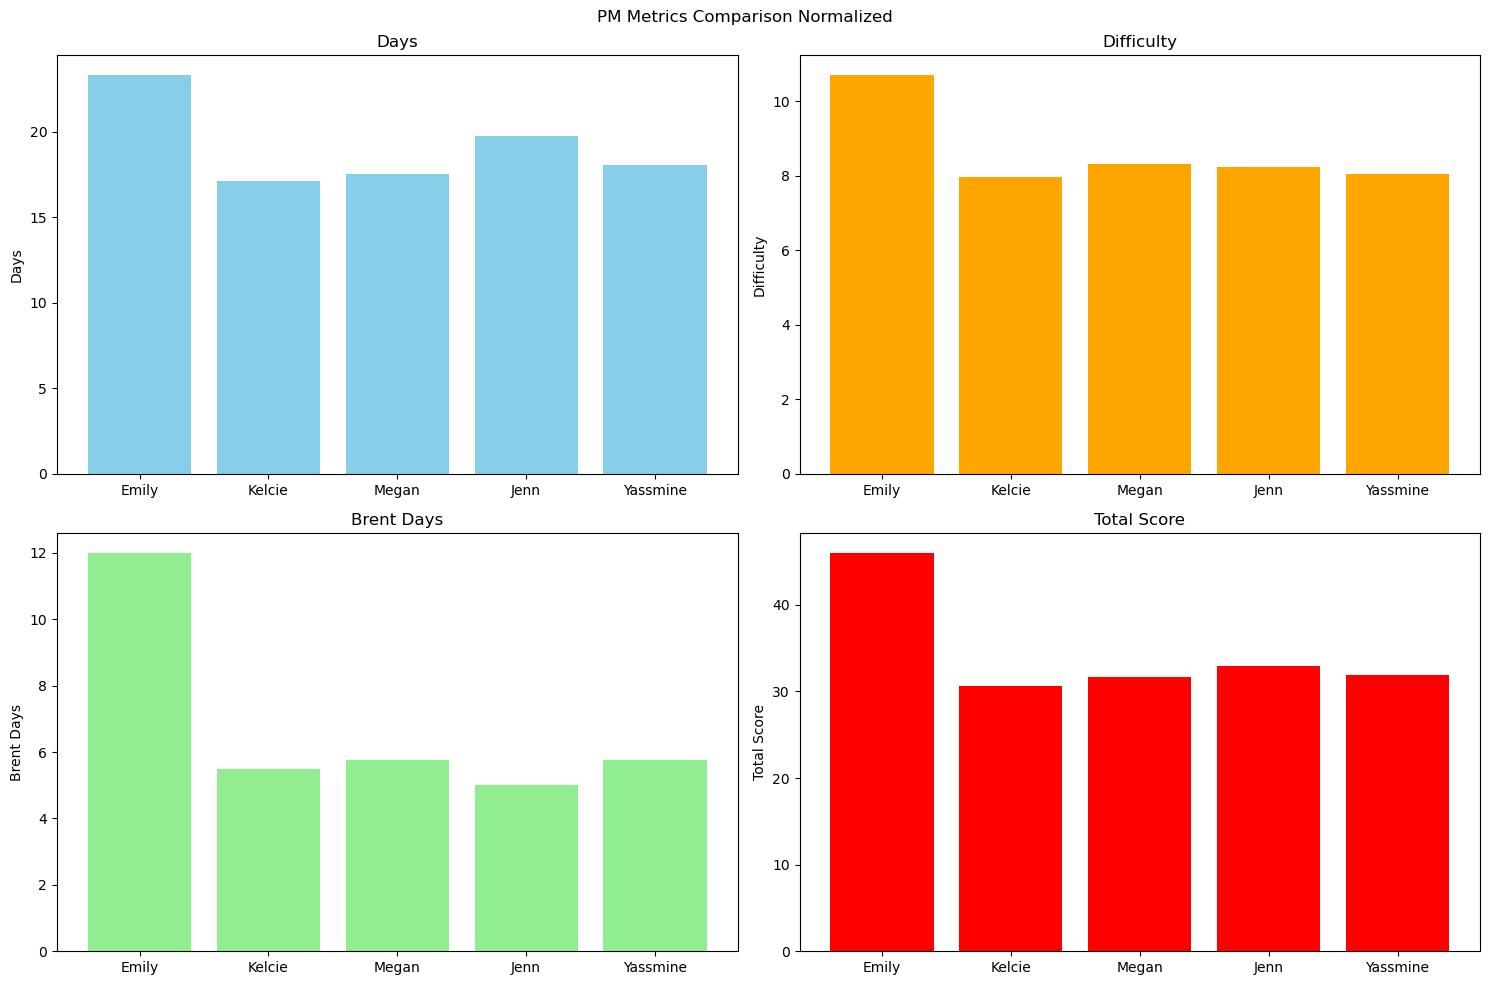

In [12]:
#visualizing the normalized data

import matplotlib.pyplot as plt

for metrics in weighted_PM.values():
    metrics['total_score'] = metrics['days'] + metrics['difficulty'] + metrics['brent_days']


# Extract data for plotting
pms = list(weighted_PM.keys())
days = [metrics['days'] for metrics in weighted_PM.values()]
difficulty = [metrics['difficulty'] for metrics in weighted_PM.values()]
brent_days = [metrics['brent_days'] for metrics in weighted_PM.values()]
total_scores = [metrics['total_score'] for metrics in weighted_PM.values()]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust the size as needed
fig.suptitle('PM Metrics Comparison Normalized')

# Plot each metric
axs[0, 0].bar(pms, days, color='skyblue')
axs[0, 0].set_title('Days')
axs[0, 0].set_ylabel('Days')

axs[0, 1].bar(pms, difficulty, color='orange')
axs[0, 1].set_title('Difficulty')
axs[0, 1].set_ylabel('Difficulty')

axs[1, 0].bar(pms, brent_days, color='lightgreen')
axs[1, 0].set_title('Brent Days')
axs[1, 0].set_ylabel('Brent Days')

axs[1, 1].bar(pms, total_scores, color='red')
axs[1, 1].set_title('Total Score')
axs[1, 1].set_ylabel('Total Score')

# Show the plot
plt.tight_layout()
plt.show()
